In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys

sys.path.append("../")

In [8]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

sns.set_style("whitegrid")

In [12]:
from pathlib import Path
from hallucinations.utils.metric_loader import get_activation_dirs, load_model_answers, load_model_metrics

data_dir = Path("../data/activations/nq_open")

activation_dirs = get_activation_dirs(data_dir)

In [13]:
activation_dirs[0]

{'model': 'llama_3.1_8b_instruct',
 'temperature': 'low',
 'prompt': 'short_few_shot_sep',
 'path': PosixPath('../data/activations/nq_open/llama_3.1_8b_instruct/sampling_low_temp_with_activations__prompt_qa/short_few_shot_sep__seed_42/activations')}

In [15]:
shard_paths = list((activation_dirs[0]["path"]).glob("*.pt"))

In [16]:
shard = torch.load(shard_paths[0], weights_only=True, mmap=True, map_location="cpu")

In [19]:
for layer_hstates in shard["hidden_states"]:
    print(layer_hstates.shape)
    break

torch.Size([64, 198, 4096])


In [21]:
for example_hstates in layer_hstates:
    print(example_hstates.shape)
    break


torch.Size([198, 4096])


In [ ]:
import math

from hallucinations.metrics.common import normalize

In [42]:
X = example_hstates.to(dtype=torch.float32, device=device)

In [63]:
Z = torch.transpose(X, 0, 1)
n = Z.shape[0]

In [66]:
J = torch.eye(n, device=Z.device) - torch.ones(n, n, device=Z.device) / n
Z_t = Z.t()
Sigma = Z_t @ J @ Z

Sigma[0, :10]


tensor([ 0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026, -0.0002,
        -0.0002, -0.0003])

In [69]:
Z_centered = Z - Z.mean(dim=0)
manual_cov_Z = Z_centered.T @ Z_centered * (1 / (n - 1))
manual_cov_Z[0, :10]

tensor([ 6.2862e-07,  6.2862e-07,  6.2862e-07,  6.2862e-07,  6.2862e-07,
         6.2862e-07,  6.2862e-07, -5.6107e-08, -5.6107e-08, -7.1963e-08])

In [71]:
torch.cov(Z.T)[0, :10]

tensor([ 6.2862e-07,  6.2862e-07,  6.2862e-07,  6.2862e-07,  6.2862e-07,
         6.2862e-07,  6.2862e-07, -5.6107e-08, -5.6107e-08, -7.1963e-08])

In [54]:
Sigma[0, :10]

tensor([ 0.0036,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026, -0.0002,
        -0.0002, -0.0003])

In [51]:
def manual_compute_cov(X):
    m, n = X.shape
    return X.T @ X * (1 / (m - 1))

X_centered = X.t() - X.t().mean(dim=0)
manual_cov_X = manual_compute_cov(X_centered)
manual_cov_X += alpha * torch.eye(manual_cov_X.shape[0], device=Z.device)


In [53]:
manual_cov_X[0, :10]

tensor([ 1.0006e-03,  6.2862e-07,  6.2862e-07,  6.2862e-07,  6.2862e-07,
         6.2862e-07,  6.2862e-07, -5.6107e-08, -5.6107e-08, -7.1963e-08])

In [72]:
torch.cov(X).shape, torch.cov(X.T).shape

(torch.Size([198, 198]), torch.Size([4096, 4096]))

In [50]:
manual_cov_X[0, :10]

tensor([1.0033e-03, 3.3130e-06, 3.3130e-06, 3.3130e-06, 3.3130e-06, 3.3130e-06,
        3.3130e-06, 9.9166e-07, 9.9166e-07, 2.6481e-06])

In [41]:
Z = example_hstates.to(dtype=torch.float32, device=device)
torch.cov(normalize(Z))[0, :10]

tensor([2.4410e-04, 2.4410e-04, 2.4410e-04, 2.4410e-04, 2.4410e-04, 2.4410e-04,
        2.4410e-04, 1.7943e-05, 1.7943e-05, 2.0384e-04])

In [28]:
Sigma.shape

torch.Size([198, 198])

In [33]:
Sigma[0, :10]

tensor([ 0.0036,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026, -0.0002,
        -0.0002, -0.0003])

In [27]:


R = example_hstates.to(dtype=torch.float32, device=device)

A = torch.cov(normalize(R))

# Get singular values
eig_val = torch.linalg.svdvals(A / torch.trace(A))

# Compute effective rank
erank = -(eig_val * torch.log(eig_val)).nansum().item()
erank = math.exp(erank)


In [36]:
A[0,:10]

tensor([2.4410e-04, 2.4410e-04, 2.4410e-04, 2.4410e-04, 2.4410e-04, 2.4410e-04,
        2.4410e-04, 1.7943e-05, 1.7943e-05, 2.0384e-04])

In [17]:
from hallucinations.utils.metric_loader import process_dataframe

metric_type = "logdet"
dfs = []

model_metrics = load_model_metrics(model_results, metric_type=metric_type)
for token_mask in ["use_token_mask", "no_token_mask"]:
    df = pd.DataFrame(model_metrics)
    df = process_dataframe(df, token_mask, metric_type=metric_type)
    dfs.append(df)

df_results = pd.concat(dfs, axis=0)

In [11]:
from tqdm.notebook import tqdm
from hallucinations.utils.metric_loader import load_model_metrics_as_df

METRICS = ["logdet"]
id_cols = ["model", "temperature", "squad_f1", "squad_exact_match", "rougeL_fmeasure", "rougeL_precision", "rougeL_recall"]

dfs_melted = {}

for metric in tqdm(METRICS):
    df_metrics = load_model_metrics_as_df(model_results, metric_type=metric)
    df_melted = df_metrics.melt(
        id_vars=id_cols,
        value_vars=[f"{metric}_layer_{i}" for i in range(33)],
        var_name="layer",
        value_name=metric
    )
    df_melted["layer"] = df_melted["layer"].str.extract("(\d+)").astype(int)
    df_melted["correct"] = df_melted["rougeL_fmeasure"].apply(lambda x: 1 if x >= 0.3 else 0)
    dfs_melted[metric] = df_melted


<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_4043788/664062309.py:17: SyntaxWarning: invalid escape sequence '\d'
  df_melted["layer"] = df_melted["layer"].str.extract("(\d+)").astype(int)


  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
# index_cols = id_cols + ["layer", "correct"]
# df_melted = pd.concat([df.set_index(index_cols) for df in dfs_melted], axis=1).reset_index()
# df_melted.head()

# Difference in logdet per layer

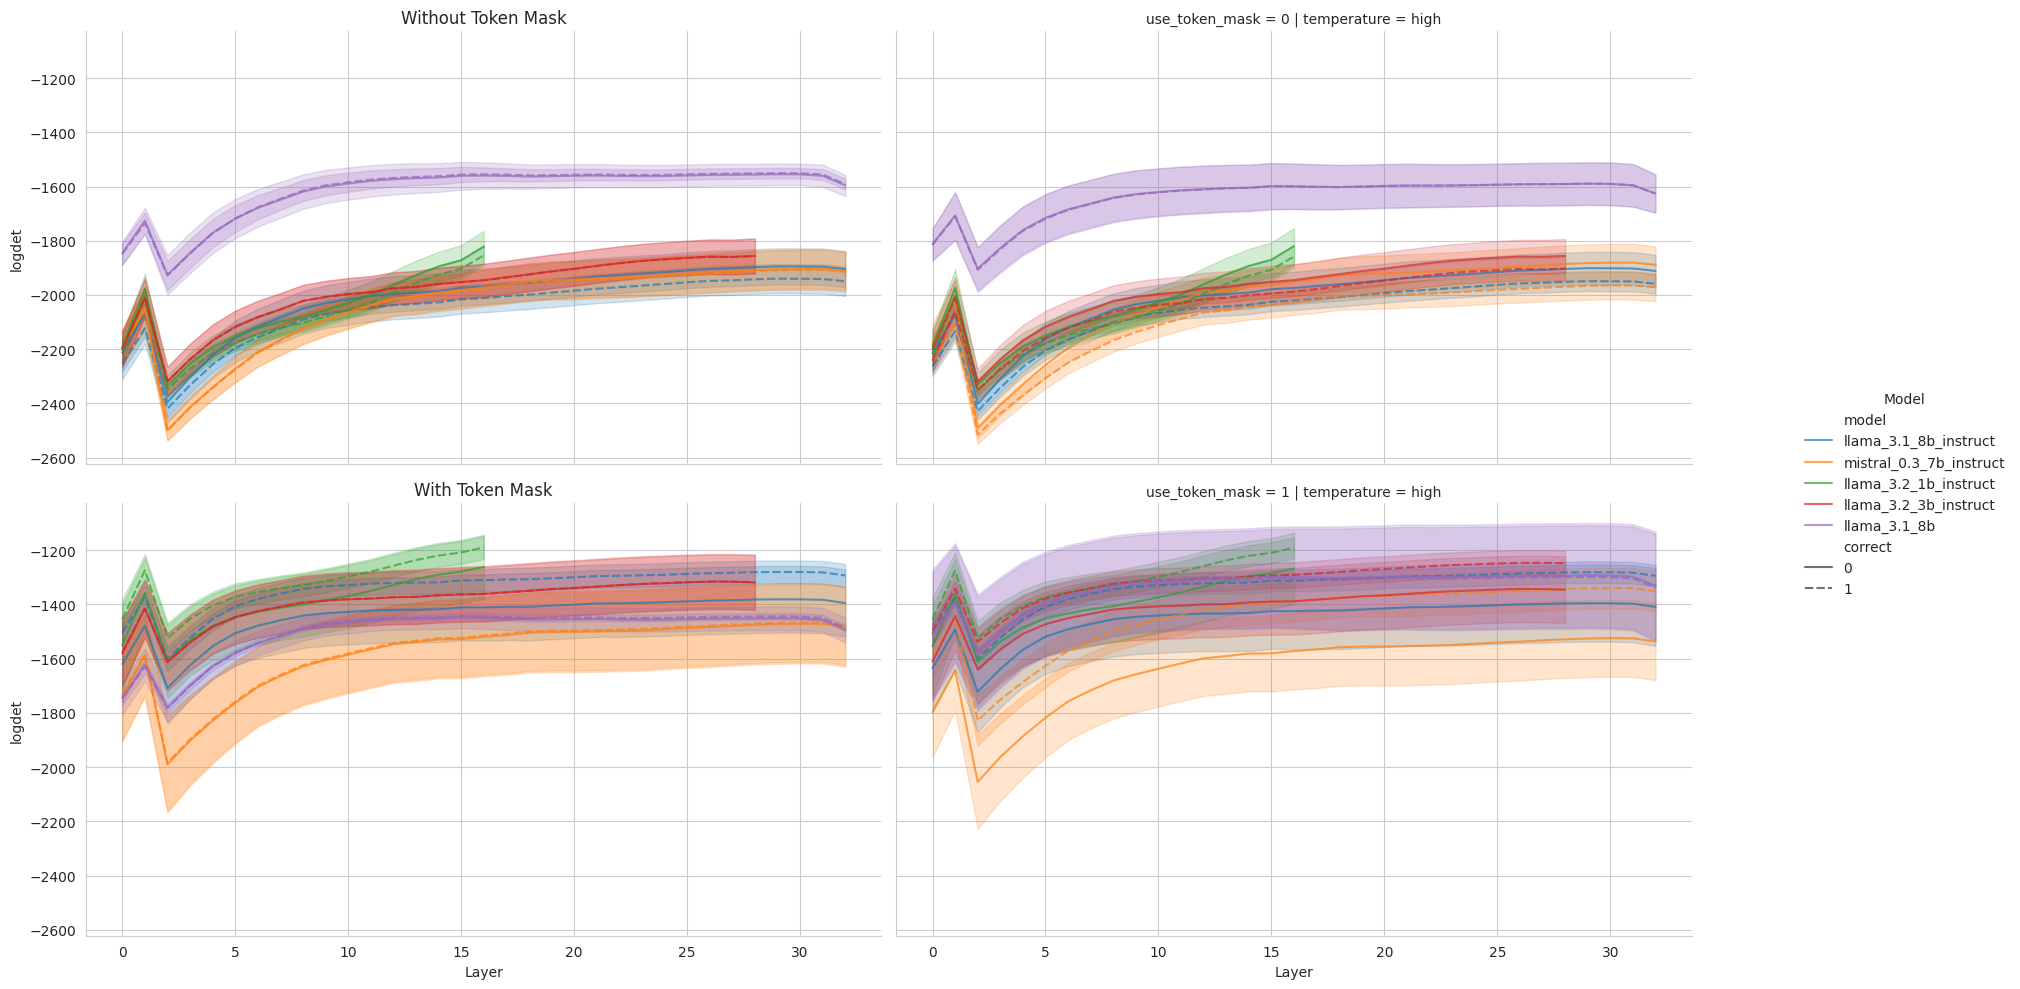

In [21]:
df_plot = df_melted.copy()
df_plot = df_plot[df_plot[metric_type] != 0.]

g = sns.FacetGrid(
    data=df_plot,
    row="use_token_mask", 
    col="temperature",
    height=5,
    aspect=1.5
)

g.map_dataframe(
    sns.lineplot,
    x="layer",
    y=metric_type,
    hue="model",
    style="correct", 
    alpha=0.7,
    errorbar="sd",
)

g.axes[0,0].set_title("Without Token Mask")
g.axes[1,0].set_title("With Token Mask")

g.set_axis_labels("Layer", metric_type)

# Move legend next to plot by adjusting bbox_to_anchor coordinates
g.add_legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title="Model")

plt.tight_layout()
plt.show()


TODO: Conclusions

# AUROC for each model and layer

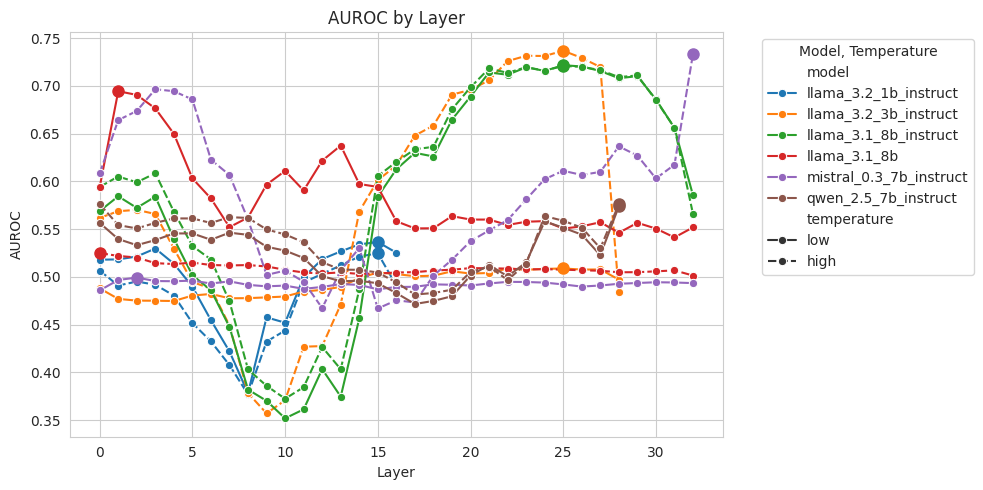

In [16]:
from sklearn.metrics import roc_auc_score

model_names = ['llama_3.2_1b_instruct', 'llama_3.2_3b_instruct', 'llama_3.1_8b_instruct', 'llama_3.1_8b', 'mistral_0.3_7b_instruct', 'qwen_2.5_7b_instruct']

metric_type = "logdet"
df_plot = dfs_melted[metric_type]
df_plot = df_plot[df_plot[metric_type].notna()]
df_plot = df_plot[df_plot[metric_type] != 0.]

auroc_results = []

for model in model_names:
    for temperature in ["low", "high"]:
        model_data = df_plot[(df_plot["model"] == model) & (df_plot["temperature"] == temperature)]
        
        layers = model_data["layer"].unique()
        
        for layer in layers:
            layer_data = model_data[model_data["layer"] == layer]
            
            if len(layer_data["correct"].unique()) < 2:
                continue
                
            auroc = roc_auc_score(layer_data["correct"], layer_data[metric_type])
            
            auroc_results.append({
                "model": model,
                "layer": layer,
                "auroc": auroc,
                "temperature": temperature
            })

auroc_df = pd.DataFrame(auroc_results)

plt.figure(figsize=(10, 5))
lines = sns.lineplot(
    data=auroc_df[auroc_df["auroc"] != 0.5],
    x="layer",
    y="auroc", 
    hue="model",
    style="temperature",
    marker="o"
)

# Add horizontal lines for max AUROC per model and mask value
for idx, (model, temperature) in enumerate([(m,v) for m in model_names for v in ["low", "high"]]):
    model_data = auroc_df[(auroc_df["model"] == model) & (auroc_df["temperature"] == temperature)]
    if len(model_data) > 0:
        model_max = model_data["auroc"].max()
        max_layer = model_data[model_data["auroc"] == model_max]["layer"].iloc[0]
        color = lines.get_lines()[idx].get_color()
        # plt.axhline(y=model_max, color=color, linestyle='--', alpha=0.5)
        plt.plot([max_layer], [model_max], 'o', color=color, markersize=8)

plt.title("AUROC by Layer")
plt.xlabel("Layer")
plt.ylabel("AUROC")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Model, Temperature")
plt.tight_layout()
plt.show()


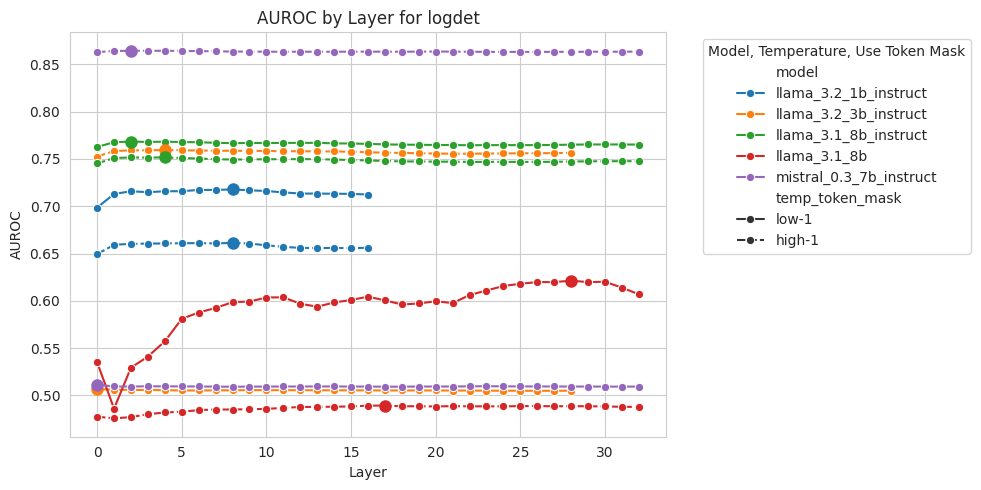

In [27]:
plt.figure(figsize=(10, 5))
lines = sns.lineplot(
    data=auroc_df[(auroc_df["auroc"] != 0.5) & (auroc_df["temp_token_mask"].isin(["low-1", "high-1"]))],
    x="layer",
    y="auroc", 
    hue="model",
    style="temp_token_mask",
    marker="o"
)

# Add horizontal lines for max AUROC per model and mask value
for idx, (model, temp_token_mask) in enumerate([(m,v) for m in model_names for v in ["low-1", "high-1"]]):
    model_data = auroc_df[(auroc_df["model"] == model) & (auroc_df["temp_token_mask"] == temp_token_mask)]
    if len(model_data) > 0:
        model_max = model_data["auroc"].max()
        max_layer = model_data[model_data["auroc"] == model_max]["layer"].iloc[0]
        color = lines.get_lines()[idx].get_color()
        # plt.axhline(y=model_max, color=color, linestyle='--', alpha=0.5)
        plt.plot([max_layer], [model_max], 'o', color=color, markersize=8)

plt.title(f"AUROC by Layer for {metric_type}")
plt.xlabel("Layer")
plt.ylabel("AUROC")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Model, Temperature, Use Token Mask")
plt.tight_layout()
plt.show()


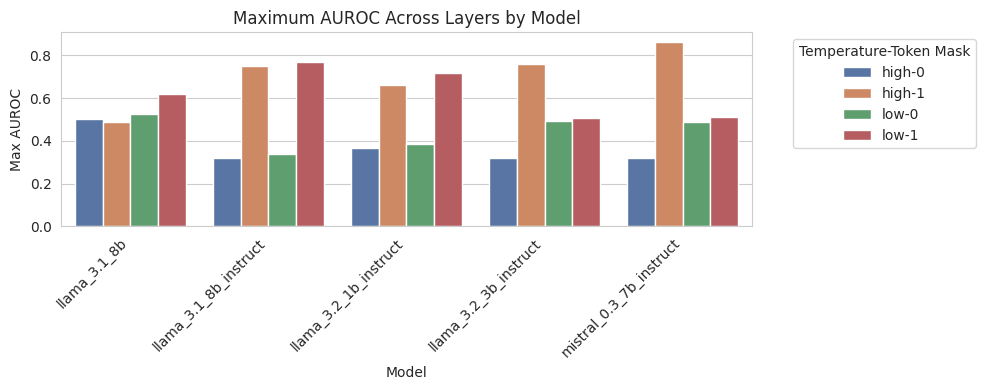

In [23]:
max_auroc_df = auroc_df.groupby(['model', 'temp_token_mask'])['auroc'].max().reset_index()

max_auroc_df['metric'] = 'Max Layer Logdet'
max_auroc_df['name'] = max_auroc_df.apply(lambda x: f"Max Layer Logdet (temp-mask={x['temp_token_mask']})", axis=1)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=max_auroc_df,
    x='model',
    y='auroc',
    hue='temp_token_mask',
    palette='deep'
)

plt.title("Maximum AUROC Across Layers by Model")
plt.xlabel("Model")
plt.ylabel("Max AUROC")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Temperature-Token Mask", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


---